#**Estimativa de Parâmetros de Qualidade da Água com Aprendizado Profundo em Séries Temporais Multivariadas**

Esse estudo tem como propósito explorar a aplicação de técnicas avançadas de aprendizado profundo na estimativa dos parâmetros de qualidade da água em Estações de Tratamento de Água (ETA). Esse projeto abarcará diversas etapas, desde a coleta e pré-processamento dos dados até a criação e avaliação de modelos. O objetivo primordial consiste em desenvolver um modelo preciso capaz de oferecer estimativas confiáveis dos parâmetros que regem a qualidade da água, algo de suma importância para a gestão ambiental.

In [ ]:
#Imports
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from sklearn.impute import KNNImputer
import missingno as msno
import seaborn as sns
from google.colab import drive
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import random
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from PIL import Image


# 1 Análise inicial dos dados para compreender sua estrutura e características

A etapa inicial de análise dos dados temporais para previsão da qualidade da água em rios e afluentes envolve uma compreensão profunda da estrutura e das características desses dados. Esse processo inclui a coleta e a organização dos dados históricos, explorando a natureza temporal das medições de qualidade da água, como pH, turbidez, níveis de oxigênio dissolvido, entre outros parâmetros. Isso requer uma análise minuciosa dos padrões sazonais, tendências e ciclos temporais presentes nos dados, bem como a detecção de possíveis outliers ou lacunas na série temporal. Além disso, compreender a relação entre os diferentes parâmetros da água e suas influências temporais pode ser fundamental para a construção de modelos de aprendizado de máquina robustos que possam fazer previsões precisas e úteis para a gestão e preservação dos recursos hídricos.

## 1.1 Coleta e Pré-processamento de Dados

Dados de qualidade de água obtidos do site https://portal.gemstat.org/ , o qual foram selecionadas 3 estações de analise do rio Guandu/RJ Brasil. As estações selecionadas foram:

* BRA00073
* BRA00005
* BRA02280

In [ ]:
drive.mount('/content/drive', force_remount=True)


arquivo_dados = '/content/drive/MyDrive/data/converted_distinct_WQI_V3.csv'
df = pd.read_csv(arquivo_dados,sep=';',header=0)

Mounted at /content/drive


Em 1976, a Companhia de Tecnologia de Saneamento Ambiental de São Paulo (CETESB) modificou o WQI da NSF (2007), criando um índice a partir do produtório ponderado de nove variáveis analíticas de qualidade de água (CETESB, 2020), conforme a Equação 2. O índice desenvolvido pela CETESB tem como propósito a avaliação da qualidade de água para fins de abastecimento público, refletindo, principalmente, a contaminação do ambiente aquático pelo lançamento de esgotos domésticos.

O índice da CETESB tem sido amplamente utilizado por diversas instituições governamentais de gestão e controle ambiental no Brasil.

https://cetesb.sp.gov.br/aguas-interiores/wp-content/uploads/sites/12/2021/09/Apendice-E-Indice-de-Qualidade-das-Aguas.pdf

As nove variáveis de qualidade de água utilizadas pelo WQI (CETESB) e seus respectivos correspondentes na massa de dados obtida do site  :




*  Potencial hidrogeniônico (pH)
*  Demanda Bioquímica de Oxigênio (BOD)
*  Fósforo Total (TP)
*  Oxigênio Dissolvido (O2Dis)
*  Nitrogênio Total (NO2N , NO3N ou NH4N)
*  Temperatura (TEMP)
*  Coliformes Fecais (FECALCOLI)
*  Resíduo Total (TS)
*  Turbidez (TURB)

In [ ]:
df

,GEMS,Date,pH,BOD,TP,O2Dis,NO3N,TEMP,FECALCOLI,NO2N,NH4N,TS,TURB
0,BRA00005,01/01/1979,6.92,1.4,0.19,7.2,0.19,NaN,3.3,0.001,NaN,NaN,NaN
1,BRA00005,01/02/1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRA00005,01/03/1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRA00005,01/04/1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRA00005,01/05/1979,6.95,2.4,0.06,7.6,0.30,23.0,2.3,0.023,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,BRA02280,01/08/2015,6.90,2.0,0.03,9.2,1.51,22.0,490.0,0.020,0.14,91.0,6.20
495,BRA02280,01/09/2015,7.30,2.0,0.09,7.6,1.50,21.0,4500.0,0.020,0.50,NaN,3.90
496,BRA02280,01/10/2015,7.00,2.0,0.08,7.6,1.24,25.0,1300.0,0.010,0.16,NaN,1.98
497,BRA02280,01/11/2015,7.10,2.0,0.08,6.8,1.32,25.0,2300.0,0.020,0.10,NaN,13.80


## 1.2 Analise do percentual de registros com todos os valores para o IQA


Percentual de linhas com dados completos para o cálculo de WQI: 4.21%


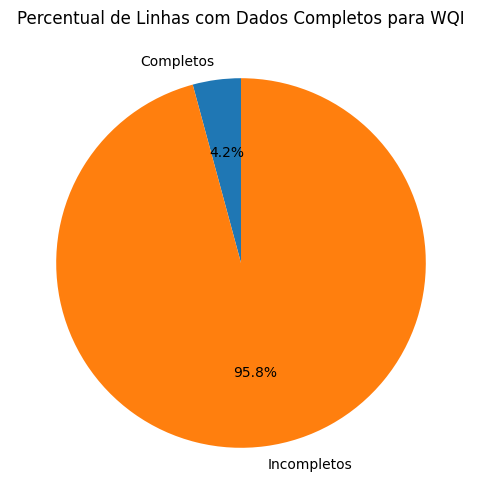

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GEMS       499 non-null    object 
 1   Date       499 non-null    object 
 2   pH         400 non-null    float64
 3   BOD        398 non-null    float64
 4   TP         354 non-null    float64
 5   O2Dis      394 non-null    float64
 6   NO3N       280 non-null    float64
 7   TEMP       347 non-null    float64
 8   FECALCOLI  224 non-null    float64
 9   NO2N       281 non-null    float64
 10  NH4N       237 non-null    float64
 11  TS         234 non-null    float64
 12  TURB       111 non-null    float64
dtypes: float64(11), object(2)
memory usage: 50.8+ KB


In [ ]:
filtered_df = df

# Verificando as linhas que possuem todos os dados necessários para o cálculo de WQI
complete_data_rows = filtered_df.dropna(subset=['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB'])

# Calculando o percentual de linhas com dados completos
percent_complete_data = (len(complete_data_rows) / len(filtered_df)) * 100
print(f"\nPercentual de linhas com dados completos para o cálculo de WQI: {percent_complete_data:.2f}%")

# Criando um gráfico de pizza com o percentual de linhas com dados completos
labels = ['Completos', 'Incompletos']
sizes = [percent_complete_data, 100 - percent_complete_data]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentual de Linhas com Dados Completos para WQI')
plt.show()

filtered_df.info()

*Com base no calculo realizado somnente 4.21% dos registros possuem todos os parametros necessários para o calculo no IQA*

## 1.3 Analise do percentual por coluna de dados preenchidos

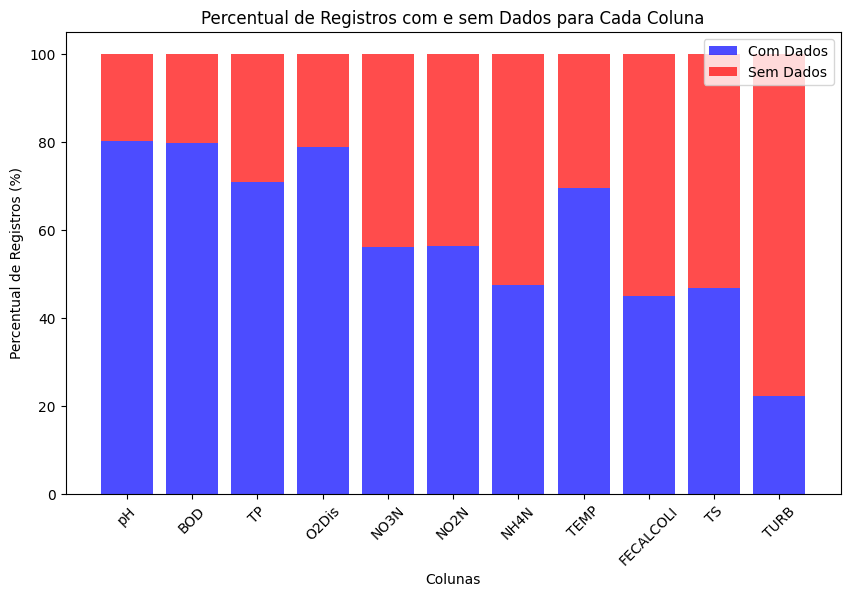

In [ ]:
# Calculando o percentual de registros com dados e sem dados para cada coluna
columns = ['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']
data_presence_percentage = []
for column in columns:
    with_data = len(df[df[column].notnull()]) / len(df) * 100
    data_presence_percentage.append(with_data)

# Calculando o percentual de registros sem dados para cada coluna
data_absence_percentage = [100 - percentage for percentage in data_presence_percentage]

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(columns, data_presence_percentage, label='Com Dados', color='b', alpha=0.7)
plt.bar(columns, data_absence_percentage, bottom=data_presence_percentage, label='Sem Dados', color='r', alpha=0.7)
plt.xlabel('Colunas')
plt.ylabel('Percentual de Registros (%)')
plt.title('Percentual de Registros com e sem Dados para Cada Coluna')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## 1.4 Analise de valores válidos para cada coluna

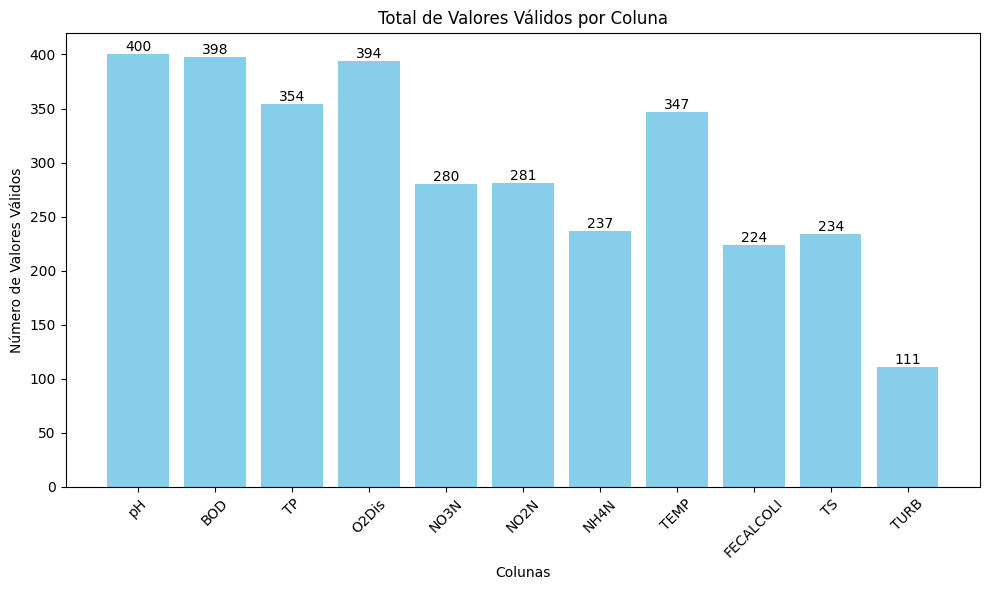

In [ ]:
# Calculando o total de valores válidos para cada coluna
valid_value_counts = df[['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']].count()

# Criando o gráfico de barras com os valores numéricos
plt.figure(figsize=(10, 6))
plt.bar(valid_value_counts.index, valid_value_counts.values, color='skyblue')
plt.xlabel('Colunas')
plt.ylabel('Número de Valores Válidos')
plt.title('Total de Valores Válidos por Coluna')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionando os valores numéricos acima das barras
for index, value in enumerate(valid_value_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


## 1.5 Analise da estação com melhor qualidade de dados

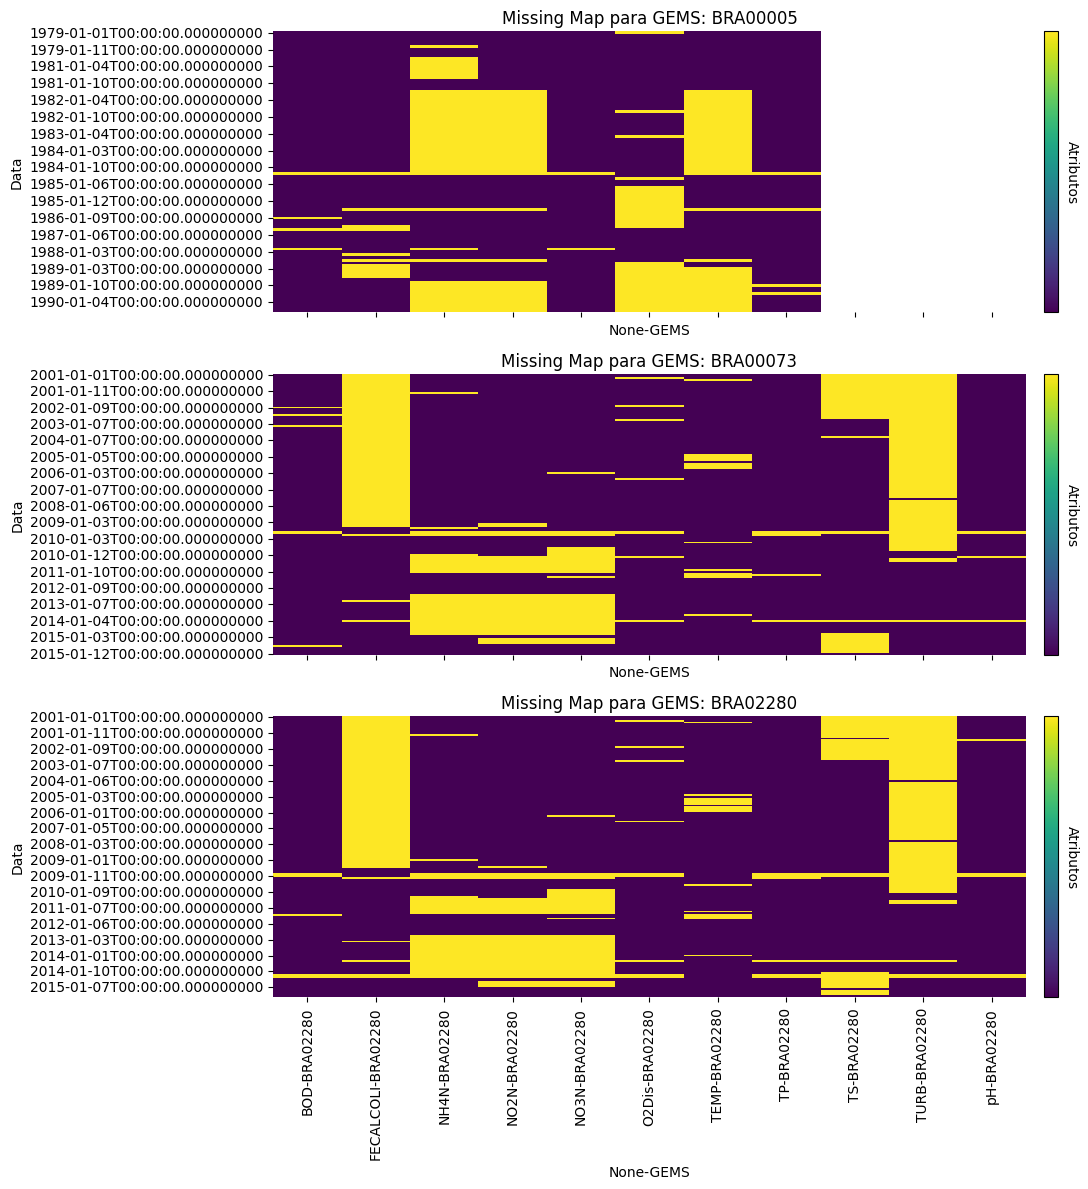

In [ ]:
# Lista das colunas de interesse
colunas_interesse = ['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']

# Convertendo 'Date' para datetime e 'GEMS' para strings
df['Date'] = pd.to_datetime(df['Date'])
df['GEMS'] = df['GEMS'].astype(str)

# Criando subplots para cada estação de GEMS
gem_stations = df['GEMS'].unique()

# Calculando o número de linhas e colunas para os subplots
num_rows = len(gem_stations)
num_cols = 1

# Criando subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), sharex=True)

# Normalizando cores para atributos
norm = mcolors.Normalize(vmin=0, vmax=len(colunas_interesse))
colors = plt.cm.viridis(norm(range(len(colunas_interesse))))

# Iterando sobre cada estação de GEMS e criando o missing map
for i, (gem_station, color) in enumerate(zip(gem_stations, colors)):
    # Filtrando o DataFrame para a estação de GEMS atual
    filtered_df = df[df['GEMS'] == gem_station]

    # Criando o missing map para a estação de GEMS atual
    sns.heatmap(filtered_df.pivot_table(index='Date', columns='GEMS', values=colunas_interesse).isnull(), cmap='viridis', cbar=False, ax=axs[i])

    # Configurando títulos e rótulos
    axs[i].set_title(f'Missing Map para GEMS: {gem_station}')
    axs[i].set_ylabel('Data')

    # Adicionando legenda das cores
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i], pad=0.02)
    cbar.set_label('Atributos', rotation=270, labelpad=15)
    cbar.set_ticks([])  # Remover os ticks da barra de cores

# Ajustando espaçamento entre os subplots
plt.tight_layout()

# Exibindo os subplots
plt.show()


In [ ]:
# Contando o número de valores não nulos para cada estação de GEMS nas colunas de interesse
dados_validos_por_gems = df.groupby('GEMS')[colunas_interesse].count().sum(axis=1)

# Identificando a estação de GEMS com mais dados válidos
gems_com_mais_dados_validos = dados_validos_por_gems.idxmax()

print(f"A estação de GEMS com mais dados válidos é: {gems_com_mais_dados_validos}")


A estação de GEMS com mais dados válidos é: BRA02280


*Com base nos calculos realizados anteriormente, a estação de tratamento mais apropriada com base no número de observações disponíveis é a **BRA02280**, sendo então escolhida esta fonte para dar seguimento ao estudo.*

## 1.6 Preechimento de valores faltantes

De forma a permitir as operações seguintes para o processo de predição, é necessário que não hajam dados faltantes. Como tecnica utilizada para tal foi selecionada a kNN: k-Nearest Neighbors, a qual encontrando vizinhos mais próximos por meio de uma métrica de distância euclidiana que suporta valores ausentes. Os valores ausentes são preenchidos pela média ponderada ou uniforme dos vizinhos mais próximos, removendo recursos sempre ausentes durante a transformação. Fonte: Scikit-learn impute techniques. Disponível em: https://scikit-learn.org/stable/modules/impute.html

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 319 to 498
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   GEMS       180 non-null    object        
 1   Date       180 non-null    datetime64[ns]
 2   pH         180 non-null    float64       
 3   BOD        180 non-null    float64       
 4   TP         180 non-null    float64       
 5   O2Dis      180 non-null    float64       
 6   NO3N       180 non-null    float64       
 7   TEMP       180 non-null    float64       
 8   FECALCOLI  180 non-null    float64       
 9   NO2N       180 non-null    float64       
 10  NH4N       180 non-null    float64       
 11  TS         180 non-null    float64       
 12  TURB       180 non-null    float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 19.7+ KB


<ipython-input-46-891e95d18f77>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[cols_to_impute] = imputer.fit_transform(filtered_data[cols_to_impute])


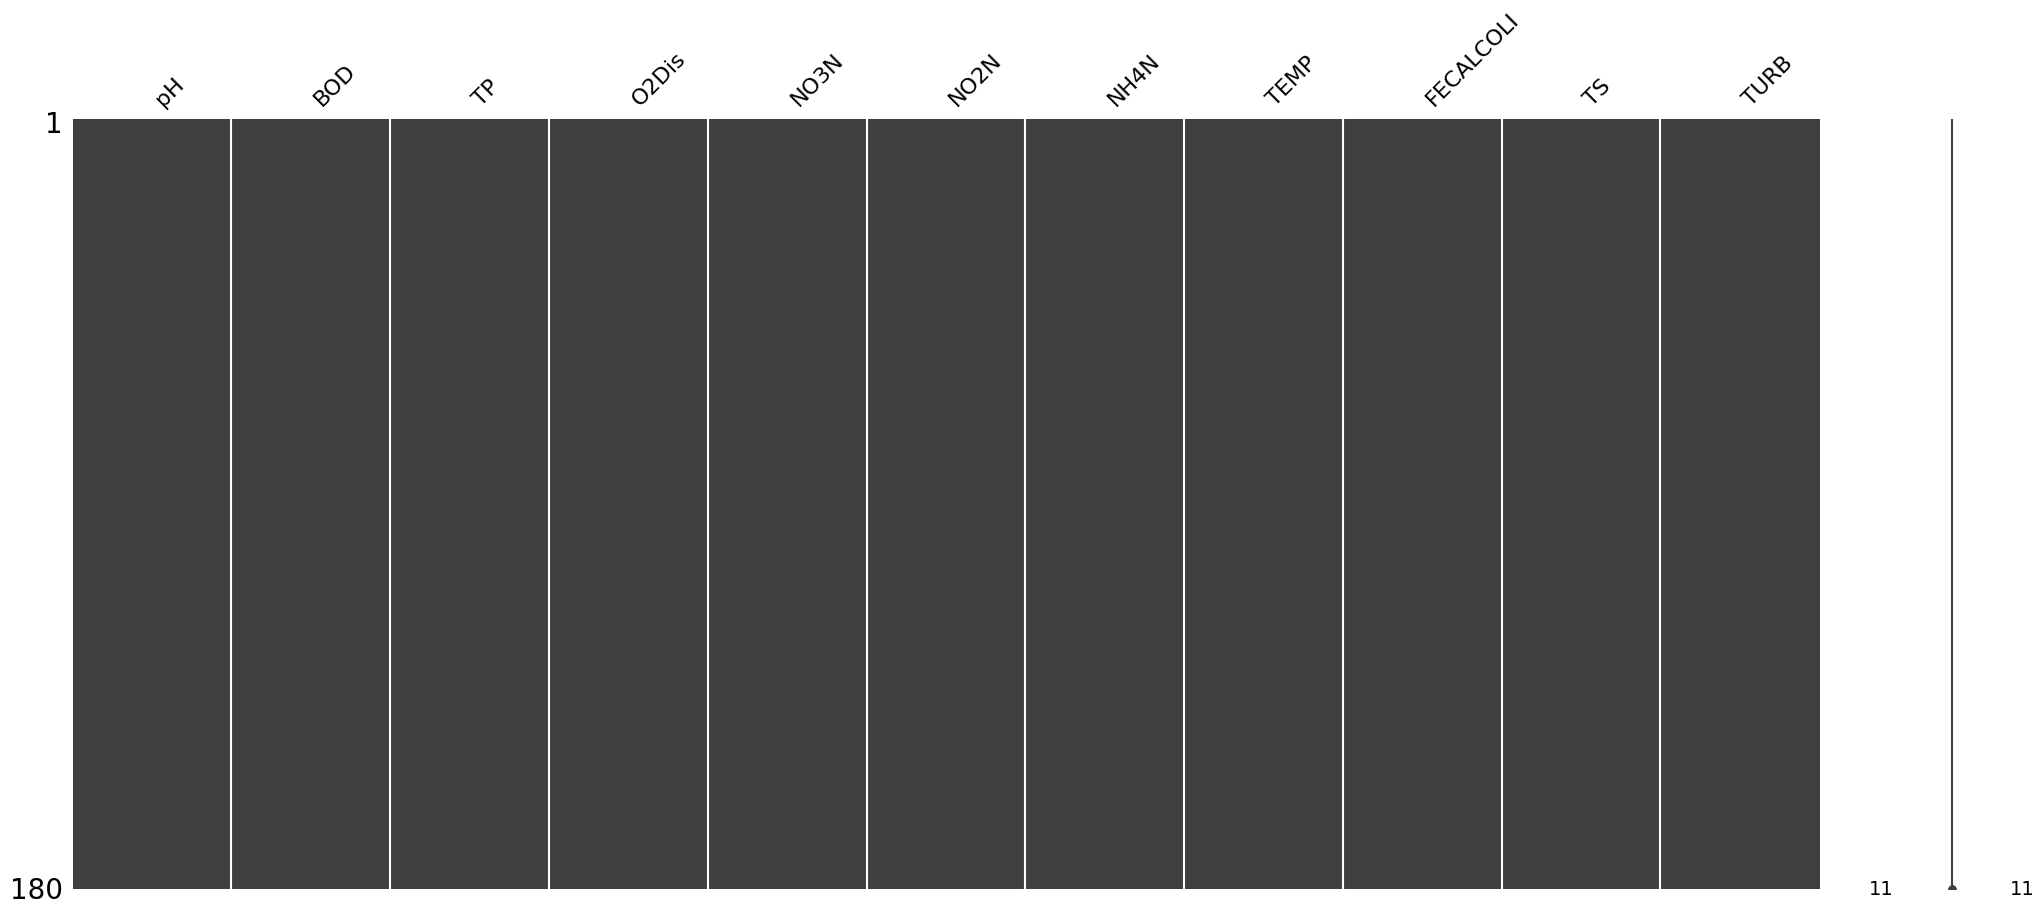

In [ ]:
# Filtro para GEMS = "BRA02280"
filtered_data = df[(df['GEMS'] == 'BRA02280')]

# Selecionando as colunas para aplicar o KNN
cols_to_impute = ['pH', 'BOD', 'TP', 'O2Dis', 'NO3N', 'NO2N', 'NH4N','TEMP', 'FECALCOLI', 'TS', 'TURB']

# Criando o objeto KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Aplicando o KNN para preencher os valores faltantes
filtered_data[cols_to_impute] = imputer.fit_transform(filtered_data[cols_to_impute])

# Gere o gráfico de missing map
msno.matrix(filtered_data[cols_to_impute])

filtered_data.info()

caminho_arquivo_kNN = '/content/drive/MyDrive/data/data_WQI_kNN_Applied.csv'
filtered_data.to_csv(caminho_arquivo_kNN, index=False)

## 1.7 Transformação de Dados Temporais
Com base nos conceitos definidos no livro Time Series Forecasting in Python( Marcos Peixeiro) capitulos 2 e 3.
Analisaremos os dados no que diz respeito as caracteristicas dos valores em relação a Observação, Tendência, Sazonalidade e Residuos no decorrer do tempo.

In [ ]:
dff = pd.read_csv(caminho_arquivo_kNN)
dff.head()

,GEMS,Date,pH,BOD,TP,O2Dis,NO3N,TEMP,FECALCOLI,NO2N,NH4N,TS,TURB
0,BRA02280,2001-01-01,6.700000,2.000000,0.200000,6.800000,0.70000,27.010000,6560.000000,0.01000,0.0800,82.200,29.800000
1,BRA02280,2001-01-02,6.980000,3.000000,0.180000,7.000000,0.25000,27.000000,7380.000000,0.01000,0.1600,80.400,18.000000
2,BRA02280,2001-01-03,6.700000,2.000000,0.100000,7.560000,0.02000,28.300000,2798.000000,0.01000,0.1000,199.800,15.240000
3,BRA02280,2001-01-04,6.929286,2.112987,0.130327,7.696333,0.47354,23.172292,13191.323529,0.02037,0.3225,115.836,18.551429
4,BRA02280,2001-01-05,6.900000,2.000000,0.070000,7.200000,0.70000,22.600000,7058.000000,0.02000,0.2000,86.800,7.616000


### 1.7.1 Transformação de Dados Temporaisa Observação, Tendência, Sazonalidade e Residuos no decorrer do tempo.

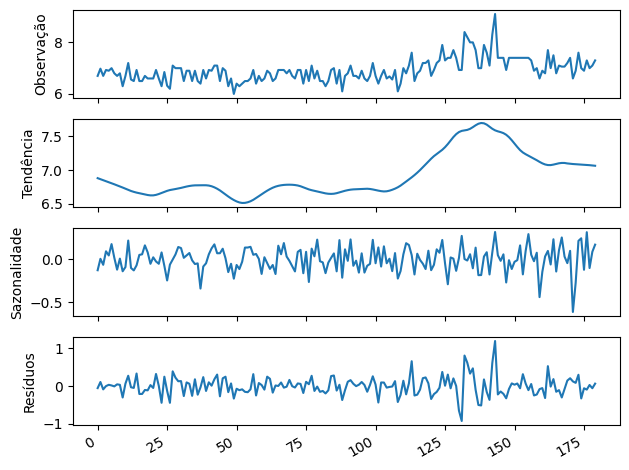

In [ ]:
advanced_decomposition = STL(dff.pH, period=12).fit() # period=12 indica sazonalidade anual

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observação')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Tendência')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Sazonalidade')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Resíduos')

#plt.xticks(np.arange(0, dff.shape[0], dff.shape[0]/11))

fig.autofmt_xdate()
plt.tight_layout()

#### 1.7.1.1  Análise
*Podemos perceber que há sazonalidade, porém a tendência geral é de constância com leve crescida e descida ao final. Com bastante erro residual.*

### 1.7.2 Identificando se serie da estação BRA02280 é Estacionária
A análise de "random walk" (caminho aleatório) em previsão de séries temporais descreve um padrão no qual os dados parecem se mover aleatoriamente ao longo do tempo, com cada ponto de dados sendo determinado pela adição de um ruído aleatório ao ponto anterior.

Já na estacionaridade de uma série as propriedades estatísticas não mudam com o tempo. Uma série temporal é dita estacionária se sua média, variância e autocorrelação não mudar com o tempo.

Depois que uma transformação é aplicada a uma série temporal, precisamos testar a estacionariedade para determinar se precisamos aplicar outra transformação para tornar a série temporal estacionária ou se precisamos mesmo transformá-la. Um teste comum é o teste Dickey-Fuller aumentado (ADF).
O teste ADF verifica a seguinte hipótese nula: existe uma raiz unitária presente em uma série temporal.
A hipótese alternativa é que não existe raiz unitária e, portanto, a série temporal é estacionária.
O resultado deste teste é a estatística ADF, que é um número negativo.
Quanto mais negativo for, mais forte será a rejeição da hipótese nula. Na sua implementação em Python, o valor p também é retornado. Se o seu valor for inferior a 0,05, também podemos rejeitar a hipótese nula e dizer que a série é estacionária.

Quando um processo estiver estacionário, traçar a função de autocorrelação (ACF) é uma ótima maneira de entender que tipo de processo você está analisando. Neste caso, iremos utilizá-lo para determinar se estamos estudando um "Random Walk" ou não.
Sabemos que a correlação mede a extensão de uma relação linear entre duas variáveis. A autocorrelação, portanto, mede a relação linear entre valores defasados de uma série temporal.
Assim, o ACF revela como a correlação entre quaisquer dois valores muda à medida que a defasagem aumenta. Aqui, o atraso é simplesmente o número de intervalos de tempo que separam dois valores.


In [ ]:
def interpretar_teste_ADF(statistic, p_value):
    # Definindo um limiar de significância comumente usado (0.05)
    limiar_significancia = 0.05

    # Verificando se a estatística ADF é menor que o valor crítico e se o valor-p é menor que o limiar de significância
    if statistic < 0 and p_value < limiar_significancia:
        return "A série é estacionária"
    else:
        return "A série não é estacionária"

#### 1.7.2.1 Analise "Random Walk" para pH no mesmo período da estação BRA02280

##### 1.7.2.1.1 Geração do "Random Walk"

2001-01-01
2015-01-12


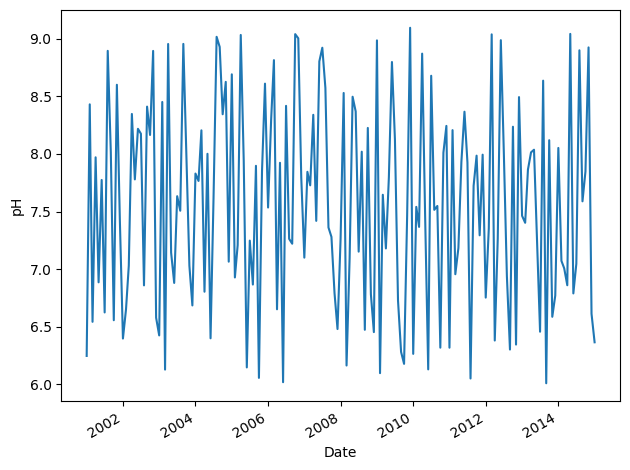

In [ ]:
# Definindo os valores mínimo e máximo para o pH
max_valor = dff['pH'].max()
min_valor = dff['pH'].min()

# Definindo os valores inicio e fim para Date
data_inicio =  dff['Date'].min()
data_fim = dff['Date'].max()

print(data_inicio)
print(data_fim)

# Criando uma lista de datas sequenciais
lista_datas = pd.date_range(start=data_inicio, end=data_fim, freq='MS')

# Gerando valores aleatórios para o pH dentro do intervalo definido
valores_ph = [random.uniform(min_valor, max_valor) for _ in range(len(lista_datas))]

# Criando o DataFrame com as colunas Date e pH
random_walk = pd.DataFrame({
    'Date': lista_datas,
    'pH': valores_ph
})

#random_walk.head()

# Exibindo as primeiras linhas do DataFrame
fig, ax = plt.subplots()

ax.plot(random_walk.Date, random_walk.pH)
ax.set_xlabel('Date')
ax.set_ylabel('pH')

fig.autofmt_xdate()
plt.tight_layout()



##### 1.7.2.1.2 Aplicando o teste ADF no Random Walk gerado

In [ ]:
ADF_result_rw = adfuller(random_walk['pH'])

print(f'ADF Statistic: {ADF_result_rw[0]}')
print(f'p-value: {ADF_result_rw[1]}')

ADF Statistic: -15.315522963081069
p-value: 4.130824727044454e-28


##### 1.7.2.1.3 Aplicando a função de Autocorrelação (ACF) no Random Walk gerado

In [ ]:
diff_result_rw = np.diff(random_walk['pH'], n=1)
ADF_diff_result_rw = adfuller(diff_result_rw)

print(f'ADF Statistic: {ADF_diff_result_rw[0]}')
print(f'p-value: {ADF_diff_result_rw[1]}')

estatistica_ADF = ADF_diff_result_rw[0]
valor_p = ADF_diff_result_rw[1]

resultado = interpretar_teste_ADF(estatistica_ADF, valor_p)
print(resultado)

ADF Statistic: -7.406524665333056
p-value: 7.320218344354419e-11
A série é estacionária


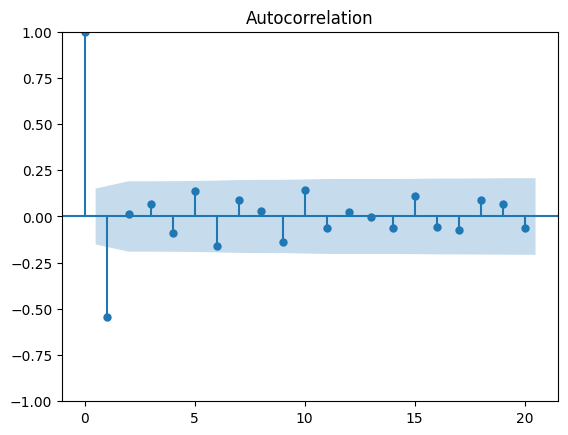

In [ ]:
plot_acf(diff_result_rw, lags=20);

imagem_acf_rw = '/content/drive/MyDrive/mestrado/figures/acf_random_walk.png'

#plt.savefig(imagem_acf_rw, dpi=300)

##### 1.7.2.1.4 Avaliação do resultado
Na geração aleatória gerada tivemos o seguinte resultado no teste ADF:

* ADF Statistic: -7.554825593334212
* p-value: 3.119502543647542e-11

O valor estatisco é negativo e p é menor que 0.05 sendo a série **estacionária**

Observamos que no gráfico ACF, vide imagem abaixo, não há coeficientes significativos após o atraso 0. Este é um indicador claro de que estamos lidando
um "random walk".

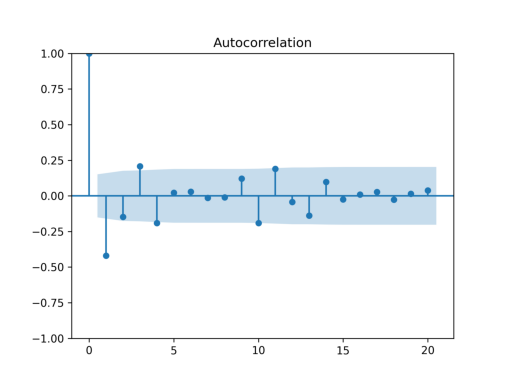

In [ ]:
# Carregar a imagem gerada anteriormente

imagem = plt.imread(imagem_acf_rw)
plt.imshow(imagem)
plt.axis('off')  # Ocultar os eixos
plt.show()

#### 1.7.2.2 Analise na série da estação BRA02280

##### 1.7.2.2.1 Aplicando o teste ADF na série da estação BRA02280

In [ ]:
BRA02280_ADF_result = adfuller(dff['pH'])

print(f'ADF Statistic: {BRA02280_ADF_result[0]}')
print(f'p-value: {BRA02280_ADF_result[1]}')

ADF Statistic: -1.1857697805454455
p-value: 0.6796870426231677


##### 1.7.2.2.2 Aplicando a função de Autocorrelação (ACF) na estação BRA02280

In [ ]:
diff_pH = np.diff(dff['pH'], n=1)
BRA02280_diff_ADF_result = adfuller(diff_pH)

print(f'ADF Statistic: {BRA02280_diff_ADF_result[0]}')
print(f'p-value: {BRA02280_diff_ADF_result[1]}')

estatistica_BRA02280_diff_ADF = BRA02280_diff_ADF_result[0]
valor_p_BRA02280_diff_ADF = BRA02280_diff_ADF_result[1]

resultado_BRA02280_diff_ADF = interpretar_teste_ADF(estatistica_ADF, valor_p)
print(resultado_BRA02280_diff_ADF)


ADF Statistic: -8.071706327976496
p-value: 1.5432932631798088e-12
A série é estacionária


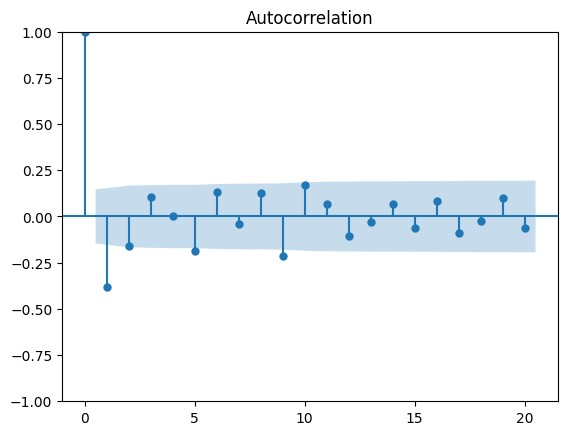

In [ ]:
plot_acf(diff_pH, lags=20);

##### 1.7.2.2.3 Avaliação do resultado
Na geração aleatória gerada tivemos o seguinte resultado no teste ADF:

* ADF Statistic: -8.071706327976496
* p-value: 1.5432932631798088e-12

O valor estatisco é negativo e p é menor que 0.05 sendo a série **estacionária**

Observamos que no gráfico ACF não há coeficientes significativos após o atraso 0. Este é um indicador claro de que estamos lidando
um "random walk".

Comparando com o analise 1.7.1.4 vemos que o comportamento é semelhante ao que "forçamos" o "random walk".

# 2 Construção e Avaliação de Modelos

## 2.1 Predição de dados "Random Walk"
Como vimos na analise anterior, os dados tem comportamento os dados tem carater aleatório ou "Random Walk".
Prever uma mudança aleatória é impossível, a menos que nós mesmos prevejamos um valor aleatório, o que não é o ideal. Neste caso, só podemos usar métodos ingénuos de previsão, ou linhas de base. Como os valores mudam aleatoriamente, nenhuma estatística modelo de aprendizagem pode ser aplicado. Em vez disso, só podemos prever razoavelmente o histórico
média ou o último valor.

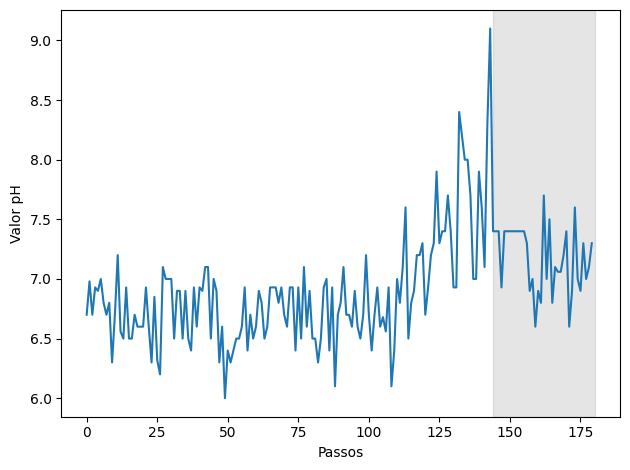

In [ ]:
dfp = pd.DataFrame({'pH': dff['pH']})


#obtem total de valores e 20% desse total
total_values = len(dfp)
test_count = int(0.2 * total_values)
train_count = total_values - test_count

#seleciona 80% para treinamento e 20% para teste
train = dfp[:train_count]
test = dfp[train_count:]
fig, ax = plt.subplots()

ax.plot(dff['pH'])
ax.set_xlabel('Passos')
ax.set_ylabel('Valor pH')
ax.axvspan(train_count, total_values, color='#808080', alpha=0.2)

plt.tight_layout()

## 2.2 Métodos de Predição
Só podemos utilizar métodos de previsão ingênuos para esta situação dados "Random Walk".
Neste caso, utilizaremos a média histórica, o último valor conhecido e o método de deriva.

### 2.2.1 Média histórica

In [ ]:
mean = np.mean(train.pH)

test.loc[:, 'pred_mean'] = mean

test.head()

<ipython-input-59-5fadd4f46f8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = mean


,pH,pred_mean
144,7.400000,6.862054
145,7.400000,6.862054
146,7.400000,6.862054
147,6.929286,6.862054
148,7.400000,6.862054


### 2.2.2 Ultimo valor

In [ ]:
last_value = train.iloc[-1].pH

test.loc[:, 'pred_last'] = last_value

test.head()

<ipython-input-60-32f5ccad996b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = last_value


,pH,pred_mean,pred_last
144,7.400000,6.862054,9.1
145,7.400000,6.862054,9.1
146,7.400000,6.862054,9.1
147,6.929286,6.862054,9.1
148,7.400000,6.862054,9.1


### 2.2.3 Método Deriva (Drift)
Por fim, aplicaremos o método de deriva.
O método de deriva é uma modificação da previsão do último valor conhecido.
Neste caso, permitimos que os valores aumentem ou diminuam ao longo do tempo.
A taxa na qual os valores mudarão no futuro é igual àquela observada no conjunto do treinos.
Portanto, equivale a calcular a inclinação entre o primeiro e o último valor do conjunto de trainos e simplesmente extrapolar esta reta para o futuro.
Podemos calcular a inclinação de uma linha reta dividindo a variação no eixo y pela variação no eixo x.
No nosso caso, a mudança no eixo y é a diferença entre o último valor do nosso passeio aleatório yf e o seu valor inicial yi.
Então o a mudança no eixo x é equivalente ao número de intervalos de tempo menos 1, conforme mostrado na equação (Livro Time Series Forecasting in Python( Marcos Peixeiro) capitulo 3):

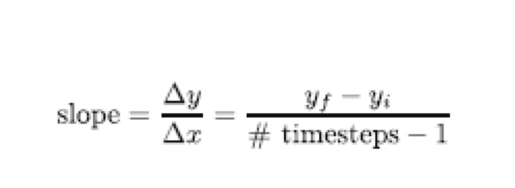

In [ ]:

caminho_imagem_equacao_drift = '/content/drive/MyDrive/mestrado/figures/equacao_drift.png'
imagem_equacao_drift = plt.imread(caminho_imagem_equacao_drift)
plt.imshow(imagem_equacao_drift)
plt.axis('off')  # Ocultar os eixos
plt.show()

In [ ]:
deltaX = train_count - 1
deltaY = last_value - 0

drift = deltaY / deltaX

x_vals = np.arange(train_count + 1, total_values + 1, 1)

pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift

test.head()

<ipython-input-62-a7bf876470de>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_drift'] = pred_drift


,pH,pred_mean,pred_last,pred_drift
144,7.400000,6.862054,9.1,9.227273
145,7.400000,6.862054,9.1,9.290909
146,7.400000,6.862054,9.1,9.354545
147,6.929286,6.862054,9.1,9.418182
148,7.400000,6.862054,9.1,9.481818


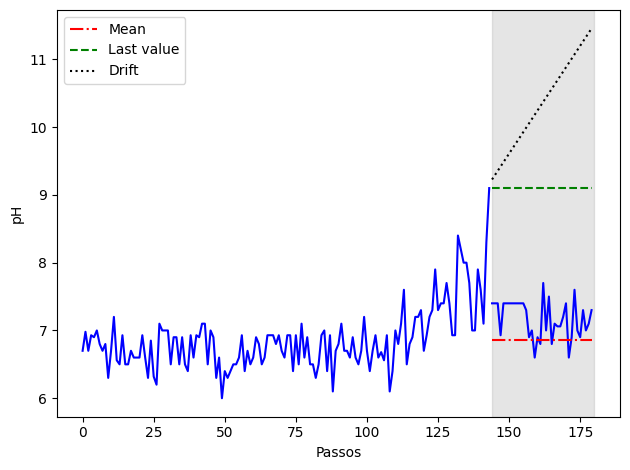

In [ ]:
fig, ax = plt.subplots()

ax.plot(train.pH, 'b-')
ax.plot(test['pH'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(train_count, total_values, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Passos')
ax.set_ylabel('pH')

plt.tight_layout()

### 2.2.4 Analise Conjunta dos métodos aplicados
Como vemos na figura acima, nossas previsões estão erradas. Todos eles não conseguem prever o aumento repentino observado no conjunto de testes, o que faz sentido, porque a mudança futura num "Random Walk" é completamente aleatória e, portanto, imprevisível.

### 2.2.5 Próximos passos

Podemos demonstrar isso ainda mais calculando o erro quadrático médio (MSE). Não é viável utilizar o MAPE (Mean Absolute Percentage Error), pois no caso do "Random Walk", existe a possibilidade de o valor ser 0, o que torna impossível calcular a diferença percentual a partir de um valor observado de 0. Isso se deve ao fato de que isso implicaria uma divisão por 0, operação não permitida na matemática.

Dessa forma, optamos pelo MSE, uma vez que ele é capaz de avaliar a precisão do ajuste de um modelo, mesmo quando o valor observado é 0. A biblioteca sklearn disponibiliza a função mean_squared_error, que requer apenas os valores observados e previstos como entrada e retorna o valor do MSE.

In [ ]:
#Calculando MSE
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['pH'], test['pred_mean'])
mse_last = mean_squared_error(test['pH'], test['pred_last'])
mse_drift = mean_squared_error(test['pH'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

0.17330485845379823 3.774866680839001 10.638282888368838


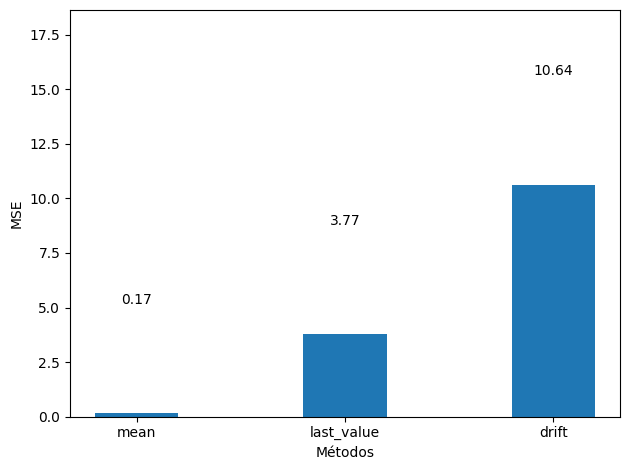

In [ ]:
#Comparativo das linhas de base MSE calculadas

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

max_value = max(mse_mean, mse_last, mse_drift)
max_value =  max_value + int(max_value * 0.8)

ax.bar(x, y, width=0.4)
ax.set_xlabel('Métodos')
ax.set_ylabel('MSE')
ax.set_ylim(0, max_value)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()

### 2.2.6 Predição do próximo passo de tempo

Prever o próximo passo de um "Random Walk" é a única situação razoável que podemos abordar, embora utilizemos métodos de previsão simples. Em particular, optamos por prever com base no último valor conhecido. No entanto, essa previsão se aplica apenas ao próximo passo de tempo. Portanto, nossa previsão pode estar incorreta apenas por causa de um valor aleatório, já que o futuro de um "Random Walk" é sempre o valor passado mais um componente de ruído branco.

A implementação desse método é direta: utilizamos o valor inicial observado para prever o próximo intervalo de tempo. Assim que obtivermos um novo valor, esse será usado como previsão para o próximo intervalo de tempo subsequente. Esse processo é então repetido no decorrer do tempo.


Vamos utilizar este método em nosso processo de "Random Walk". Para demonstrar essa abordagem, aplicaremos em toda a extensão do "Random Walk". Embora essa previsão simples possa parecer surpreendentemente precisa, na verdade, estamos apenas projetando o último valor conhecido em cada intervalo de tempo.

Uma forma eficaz de simular esse procedimento é deslocar nossos dados. A biblioteca Pandas oferece um método chamado shift, que realiza exatamente essa operação. Basta fornecer o número de períodos desejados, que no nosso caso é 1, pois estamos prevendo o próximo intervalo de tempo.

In [ ]:
df_shift = dfp.shift(periods=1)

df_shift.head()

,pH
0,NaN
1,6.700000
2,6.980000
3,6.700000
4,6.929286


Utilizando o valor observado atual como uma previsão para o próximo intervalo de tempo.

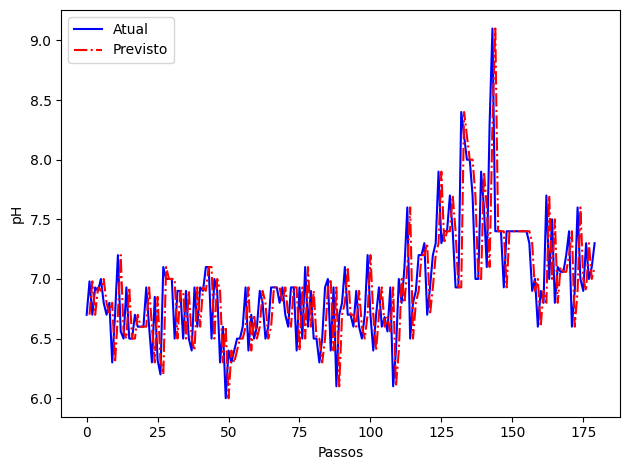

In [ ]:
fig, ax = plt.subplots()

ax.plot(dfp, 'b-', label='Atual')
ax.plot(df_shift, 'r-.', label='Previsto')

ax.legend(loc=2)

ax.set_xlabel('Passos')
ax.set_ylabel('pH')

plt.tight_layout()

Uma previsão ingênua do próximo passo de um "Random Walk". Este enredo dá
a ilusão de um modelo muito bom, quando na verdade estamos apenas prevendo o valor observado no passo de tempo anterior.

### 2.2.6 Aplicando calculo Erro Quadrático Médio (MSE)

Calcular o Erro Quadrático Médio (MSE) em um conjunto de dados do tipo "Random Walk" pode ser uma maneira útil de avaliar a precisão das previsões em relação aos valores reais. Mesmo que o "Random Walk" seja um processo estocástico no qual os próximos valores são derivados dos valores anteriores com a adição de ruído aleatório, ainda é possível avaliar a eficácia das previsões usando o MSE por algumas razões:

* Medição da Precisão:
O MSE mede a média dos quadrados dos erros entre os valores previstos e os valores reais. Apesar de um "Random Walk" ser uma série de dados imprevisíveis na prática, o cálculo do MSE pode ajudar a entender o quão bem o modelo se ajusta a esses dados imprevisíveis.

* Comparação de Modelos:
Ao testar diferentes métodos ou modelos de previsão em um "Random Walk", o cálculo do MSE permite comparar a precisão relativa entre esses métodos. Isso pode ajudar a determinar qual método se sai melhor, mesmo que todos os métodos apresentem desafios na previsão do "Random Walk".

* Avaliação da Estimativa de Tendência:
Embora prever um "Random Walk" seja difícil devido à natureza aleatória dos dados, é possível que um modelo seja capaz de capturar uma tendência subjacente, como uma direção geral ou padrão. O MSE pode ajudar a avaliar quão bem o modelo captura essa possível tendência, mesmo que não seja capaz de prever os valores individuais com precisão.

In [ ]:
mse_one_step = mean_squared_error(test['pH'], df_shift[train_count:])

mse_one_step

0.2181762188208617

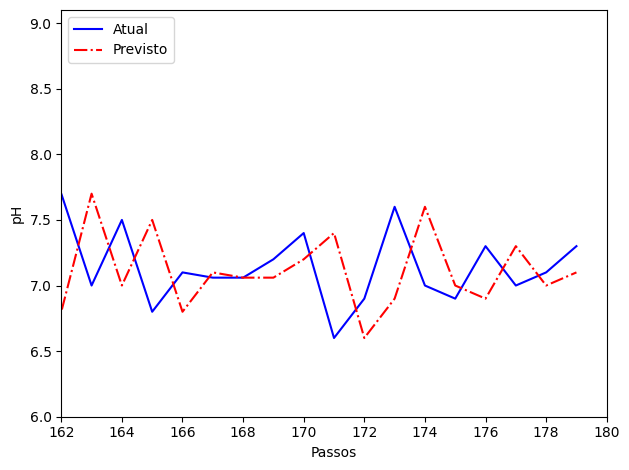

In [ ]:
fig, ax = plt.subplots()

ax.plot(dfp, 'b-', label='Atual')
ax.plot(df_shift, 'r-.', label='Previsto')

ax.legend(loc=2)

test_count_mse = int(0.1 * total_values)
train_count_mse = total_values - test_count_mse

ax.set_xlim(train_count_mse, total_values)
ax.set_ylim(min_valor, max_valor)

ax.set_xlabel('Passos')
ax.set_ylabel('pH')

plt.tight_layout()

## 2.3 Análise dos resultados

Comparando o valor do resultado 0.21 (mse_one_step) com a da beseline 0.17 (mean) poderia induzir à ideia de um desempenho excepcional do modelo, dado que o MSE está quase atingindo o valor 0. No entanto, é crucial ter em mente que estamos, na verdade, prevendo apenas o valor observado no intervalo de tempo anterior.


# 3 Conclusão

A complexidade da previsão de séries temporais, como em outras formas de predição, muitas vezes está intrinsecamente ligada à qualidade, ao tratamento e à avaliação dos dados envolvidos.

Ao empregar o método k-Nearest Neighbors (kNN) para lidar com dados ausentes, foi possível inferir que a série temporal exibia características de um “Random Walk”. Nesse cenário, cada ponto de dados é determinado pela adição de um valor aleatório ao ponto de dados anterior. Essa conclusão foi embasada na análise da função de autocorrelação (ACF) e no teste Dickey-Fuller aumentado (ADF). Para além das técnicas empregadas, a aleatoriedade da série de dados pode ter sido influenciada pelo intervalo de coleta e pela qualidade dos dados. Esses fatores adicionais podem ter desempenhado um papel significativo na direção da inferência realizada.

Quando se trata de prever um processo de "Random Walk", é mais aconselhável realizar múltiplas previsões de curto prazo. Essa abordagem visa evitar a acumulação de muitos números aleatórios ao longo do tempo, o que, por sua vez, comprometeria a precisão de nossas previsões a longo prazo. No estudo exemplificado utlizamos o calculo do Quadrático Médio (MSE) para previsão.

A natureza aleatória de um "Random Walk" implica desafios significativos na previsão, já que os passos aleatórios em direção ao futuro dificultam a aplicação de técnicas estatísticas ou de aprendizado profundo para modelar esse processo. Na realidade, não há padrões ou informações a serem aprendidos a partir da aleatoriedade, e essa imprevisibilidade torna-se intrínseca ao processo. Portanto, em vez de buscar métodos avançados de modelagem, é mais sensato confiar em abordagens de previsão mais simples e ingênuas para lidar com um "Random Walk".

# 4 Referências

* Obtenção da massa de dados utilizada
  https://portal.gemstat.org/

* Varáveis e pesos necessários para o calculo do IQA
  https://cetesb.sp.gov.br/aguas-interiores/wp-content/uploads/sites/12/2021/09/Apendice-E-Indice-de-Qualidade-das-Aguas.pdf

* Preenchimento de dados faltantes
  https://scikit-learn.org/stable/modules/impute.html

* Transformação e Análise de predição de Dados Temporais  
  *Livro - Time Series Forecasting in Python - 2022*
  *Marco Peixeiro (Autor)*
